# Simulation Results
Initially I ran the simulation experiments because I expected that my model training issues were due to noise in the data. However, I found that when using linearly separable simulated data, the models still failed to train. I fixed the models by clipping their gradients and correcting a few bugs, and ran them on the simulated data to see if they work. These are the results:

In [1]:
import collections
import glob
import json
import os
import pickle

import numpy as np
import pandas as pd
import umap
from plotnine import *

from saged.utils import parse_map_file, split_sample_names, create_dataset_stat_df

## Sepsis classification

In [2]:
in_files = glob.glob('../../results/simulation_clipped.sepsis*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/simulation_clipped.sepsis.deep_net.1.tsv', '../../results/simulation_clipped.sepsis.logistic_regression.1.tsv', '../../results/simulation_clipped.sepsis.pytorch_supervised.2.tsv', '../../results/simulation_clipped.sepsis.deep_net.2.tsv', '../../results/simulation_clipped.sepsis.pytorch_supervised.0.tsv']


In [3]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,1.0000,1.000000,1.000000,"Experiment_healthy_515,Experiment_sepsis_124,E...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",156,0.1,deep_net,1,156
1,1.0000,1.000000,1.000000,"Experiment_sepsis_492,Experiment_sepsis_332,Ex...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",312,0.2,deep_net,1,312
2,0.7775,0.772959,0.820926,"Experiment_sepsis_492,Experiment_sepsis_332,Ex...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",468,0.3,deep_net,1,468
3,1.0000,1.000000,1.000000,"Experiment_sepsis_492,Experiment_sepsis_332,Ex...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",624,0.4,deep_net,1,624
4,1.0000,1.000000,1.000000,"Experiment_sepsis_492,Experiment_sepsis_332,Ex...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",780,0.5,deep_net,1,780
...,...,...,...,...,...,...,...,...,...,...,...
45,0.9925,0.992925,0.992874,"Experiment_sepsis_192,Experiment_sepsis_676,Ex...","sepsis_993,sepsis_937,sepsis_413,sepsis_353,se...","healthy_0,healthy_4,healthy_9,healthy_10,healt...",891,0.6,three_layer_net,1,891
46,0.9925,0.992925,0.992874,"Experiment_sepsis_192,Experiment_sepsis_676,Ex...","sepsis_993,sepsis_937,sepsis_413,sepsis_353,se...","healthy_0,healthy_4,healthy_9,healthy_10,healt...",1040,0.7,three_layer_net,1,1040
47,1.0000,1.000000,1.000000,"Experiment_sepsis_192,Experiment_sepsis_676,Ex...","sepsis_993,sepsis_937,sepsis_413,sepsis_353,se...","healthy_0,healthy_4,healthy_9,healthy_10,healt...",1188,0.8,three_layer_net,1,1188
48,1.0000,1.000000,1.000000,"Experiment_healthy_462,Experiment_healthy_62,E...","sepsis_993,sepsis_937,sepsis_413,sepsis_353,se...","healthy_0,healthy_4,healthy_9,healthy_10,healt...",1337,0.9,three_layer_net,1,1337


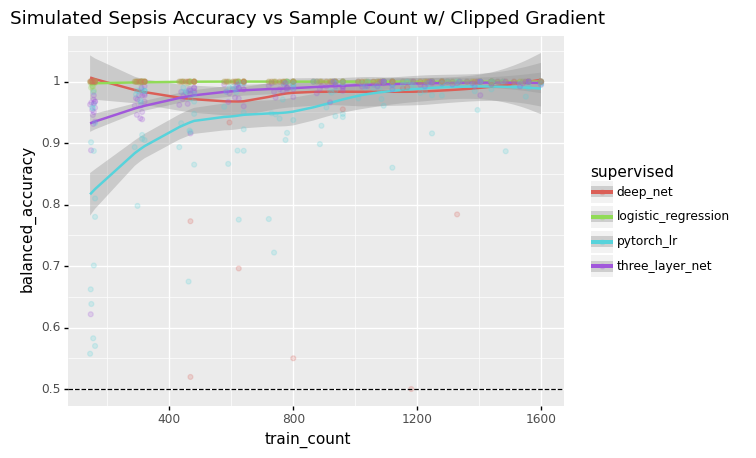

<ggplot: (8742222627921)>

In [4]:
plot = ggplot(sepsis_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count w/ Clipped Gradient')
plot

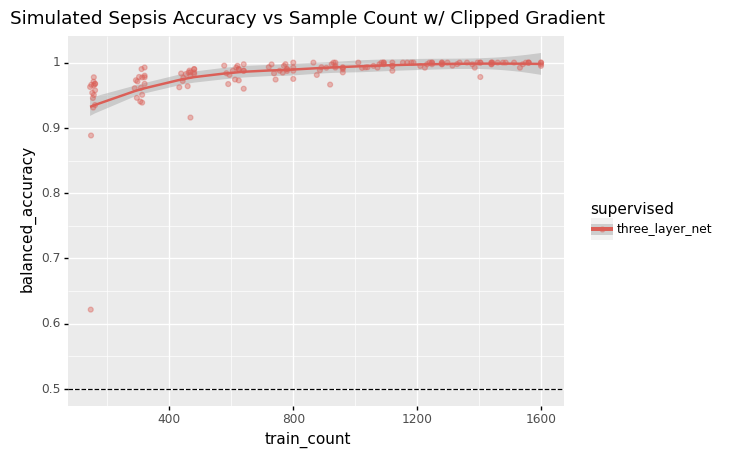

<ggplot: (8742113464225)>

In [5]:
plot = ggplot(sepsis_metrics[sepsis_metrics['supervised'] == 'three_layer_net'], aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.4)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count w/ Clipped Gradient')
plot

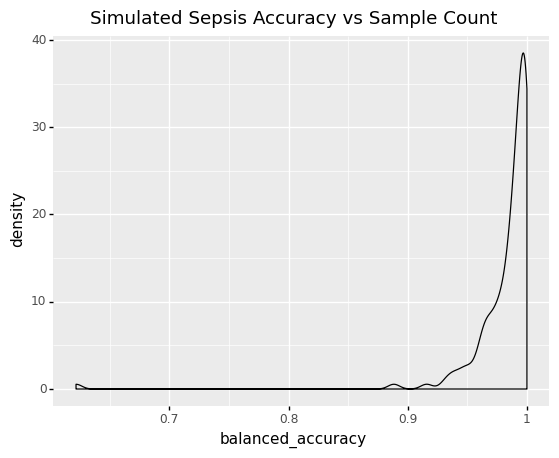

<ggplot: (8742222625405)>

In [6]:
plot = ggplot(sepsis_metrics[sepsis_metrics['supervised'] == 'three_layer_net'], aes(x='balanced_accuracy')) 
plot += geom_density()
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count')
plot

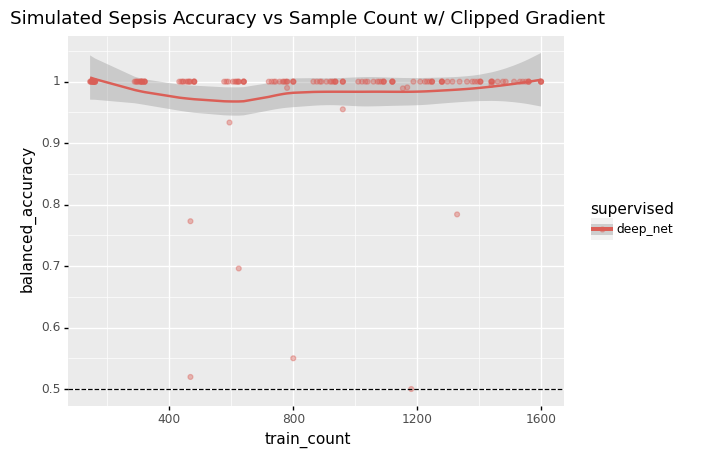

<ggplot: (8742113407473)>

In [7]:
plot = ggplot(sepsis_metrics[sepsis_metrics['supervised'] == 'deep_net'], aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.4)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated Sepsis Accuracy vs Sample Count w/ Clipped Gradient')
plot

## Simulated TB

In [8]:
in_files = glob.glob('../../results/simulation_clipped.tb*.tsv')
in_files = [file for file in in_files if 'be_corrected' not in file]
print(in_files[:5])

['../../results/simulation_clipped.tb.pytorch_lr.0.tsv', '../../results/simulation_clipped.tb.logistic_regression.2.tsv', '../../results/simulation_clipped.tb.pytorch_lr.1.tsv', '../../results/simulation_clipped.tb.deep_net.2.tsv', '../../results/simulation_clipped.tb.logistic_regression.0.tsv']


In [9]:
tb_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('tb.')[-1]
    model_info = model_info.split('.')
        
    supervised_model = model_info[0]
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
        
    tb_metrics = pd.concat([tb_metrics, new_df])
    
tb_metrics['train_count'] = tb_metrics['train sample count']

tb_metrics['supervised'] = tb_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
tb_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,train_count
0,0.9675,0.969767,0.968825,"Experiment_tb_63,Experiment_tb_192,Experiment_...","tb_650,tb_475,tb_356,tb_48,tb_400,healthy_349,...","tb_2,tb_10,tb_16,tb_18,tb_23,tb_26,tb_31,tb_36...",146,0.1,pytorch_lr,0,146
1,0.9750,0.973350,0.977169,"Experiment_tb_318,Experiment_healthy_305,Exper...","tb_650,tb_475,tb_356,tb_48,tb_400,healthy_349,...","tb_2,tb_10,tb_16,tb_18,tb_23,tb_26,tb_31,tb_36...",292,0.2,pytorch_lr,0,292
2,0.7625,0.779070,0.716418,"Experiment_tb_472,Experiment_tb_48,Experiment_...","tb_650,tb_475,tb_356,tb_48,tb_400,healthy_349,...","tb_2,tb_10,tb_16,tb_18,tb_23,tb_26,tb_31,tb_36...",438,0.3,pytorch_lr,0,438
3,0.9925,0.993023,0.992974,"Experiment_tb_472,Experiment_tb_48,Experiment_...","tb_650,tb_475,tb_356,tb_48,tb_400,healthy_349,...","tb_2,tb_10,tb_16,tb_18,tb_23,tb_26,tb_31,tb_36...",584,0.4,pytorch_lr,0,584
4,0.9975,0.997297,0.997680,"Experiment_tb_472,Experiment_tb_48,Experiment_...","tb_650,tb_475,tb_356,tb_48,tb_400,healthy_349,...","tb_2,tb_10,tb_16,tb_18,tb_23,tb_26,tb_31,tb_36...",730,0.5,pytorch_lr,0,730
...,...,...,...,...,...,...,...,...,...,...,...
45,1.0000,1.000000,1.000000,"Experiment_tb_768,Experiment_tb_56,Experiment_...","tb_993,tb_937,tb_413,tb_353,tb_922,healthy_706...","tb_0,tb_16,tb_20,tb_23,tb_24,tb_29,tb_31,tb_36...",891,0.6,logistic_regression,1,891
46,1.0000,1.000000,1.000000,"Experiment_tb_768,Experiment_tb_56,Experiment_...","tb_993,tb_937,tb_413,tb_353,tb_922,healthy_706...","tb_0,tb_16,tb_20,tb_23,tb_24,tb_29,tb_31,tb_36...",1040,0.7,logistic_regression,1,1040
47,1.0000,1.000000,1.000000,"Experiment_tb_768,Experiment_tb_56,Experiment_...","tb_993,tb_937,tb_413,tb_353,tb_922,healthy_706...","tb_0,tb_16,tb_20,tb_23,tb_24,tb_29,tb_31,tb_36...",1188,0.8,logistic_regression,1,1188
48,1.0000,1.000000,1.000000,"Experiment_tb_768,Experiment_tb_439,Experiment...","tb_993,tb_937,tb_413,tb_353,tb_922,healthy_706...","tb_0,tb_16,tb_20,tb_23,tb_24,tb_29,tb_31,tb_36...",1337,0.9,logistic_regression,1,1337


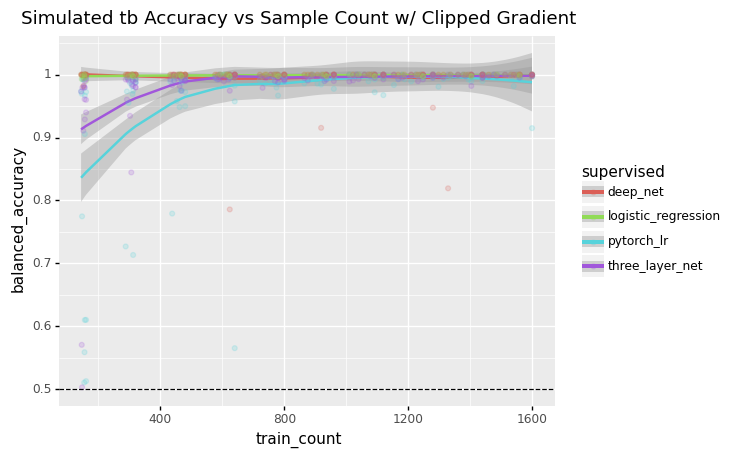

<ggplot: (8742107517865)>

In [10]:
plot = ggplot(tb_metrics, aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.2)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated tb Accuracy vs Sample Count w/ Clipped Gradient')
plot

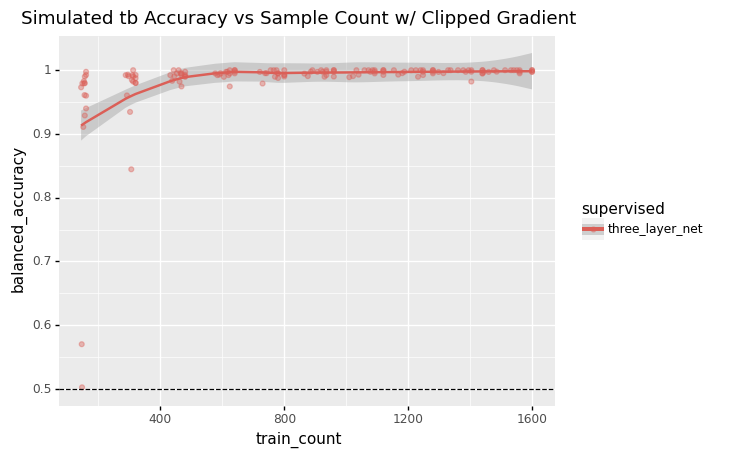

<ggplot: (8742107452621)>

In [11]:
plot = ggplot(tb_metrics[tb_metrics['supervised'] == 'three_layer_net'], aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.4)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated tb Accuracy vs Sample Count w/ Clipped Gradient')
plot

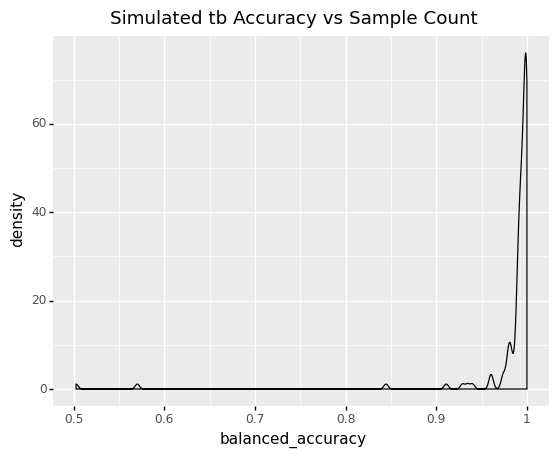

<ggplot: (8742107478997)>

In [12]:
plot = ggplot(tb_metrics[tb_metrics['supervised'] == 'three_layer_net'], aes(x='balanced_accuracy')) 
plot += geom_density()
plot += ggtitle('Simulated tb Accuracy vs Sample Count')
plot

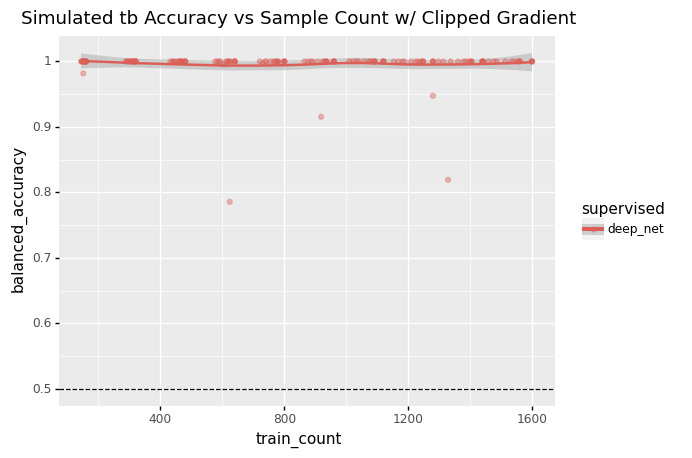

<ggplot: (8742107411541)>

In [13]:
plot = ggplot(tb_metrics[tb_metrics['supervised'] == 'deep_net'], aes(x='train_count', y='balanced_accuracy', color='supervised')) 
plot += geom_smooth()
plot += geom_point(alpha=.4)
plot += geom_hline(yintercept=.5, linetype='dashed')
plot += ggtitle('Simulated tb Accuracy vs Sample Count w/ Clipped Gradient')
plot

## Disease Vector Simulations

### Visualize Data

In [14]:
def embed_data(disease_file, healthy_file):
    with open(disease_file, 'rb') as in_file:
        disease_array = pickle.load(in_file).T

    with open(healthy_file, 'rb') as in_file:
        healthy_array = pickle.load(in_file).T
    healthy_array.shape

    joint_array = np.concatenate((disease_array, healthy_array))
    joint_array.shape

    reducer = umap.UMAP(random_state=42)

    umap_data = reducer.fit_transform(joint_array)
    umap_data.shape

    labels = ['disease_sim'] * 1000 + ['healthy_sim'] * 1000

    umap_df = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2'])
    umap_df['label'] = labels

    return umap_df

In [15]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_0.0.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,4.604673,9.191781,disease_sim
1,8.389840,8.644828,disease_sim
2,5.814624,9.132166,disease_sim
3,8.548853,6.545083,disease_sim
4,10.220934,4.133276,disease_sim


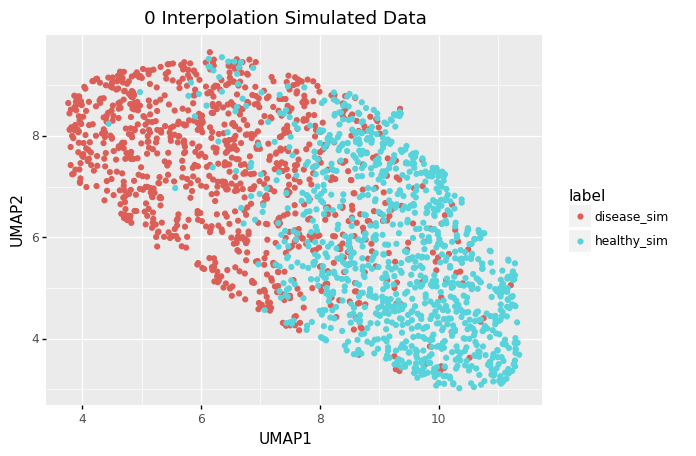

<ggplot: (8742083071189)>

In [16]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('0 Interpolation Simulated Data')
plot

#### 0.2 Interpolation Factor

In [17]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_0.2.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,2.731491,5.966238,disease_sim
1,5.223094,7.363570,disease_sim
2,3.862132,6.242798,disease_sim
3,6.932718,5.427366,disease_sim
4,10.258367,6.677005,disease_sim


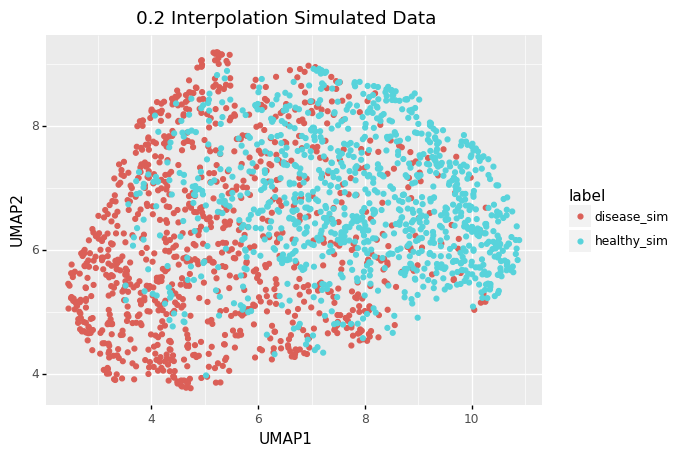

<ggplot: (8742113405873)>

In [18]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('0.2 Interpolation Simulated Data')
plot

#### 0.4 Interpolation Factor

In [19]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_0.4.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,3.584258,7.129542,disease_sim
1,6.249699,7.824802,disease_sim
2,5.186610,6.701987,disease_sim
3,7.738147,5.302823,disease_sim
4,10.516994,5.929383,disease_sim


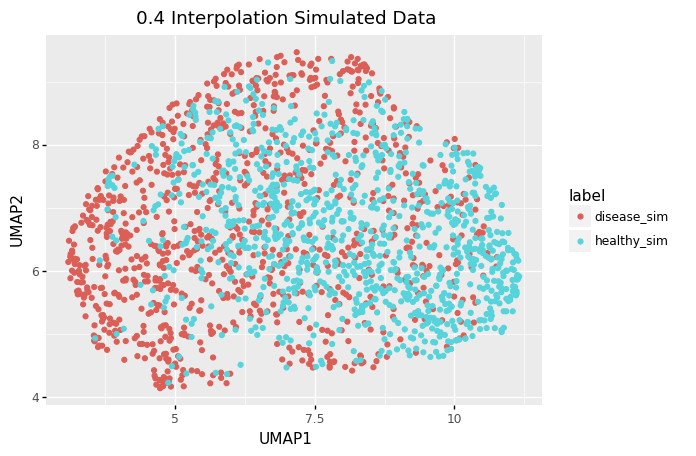

<ggplot: (8742107384537)>

In [20]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('0.4 Interpolation Simulated Data')
plot

#### 0.6  Interpolation Factor

In [21]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_0.6.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,2.503109,4.969246,disease_sim
1,5.054308,6.796084,disease_sim
2,3.863501,5.632369,disease_sim
3,7.293001,4.773901,disease_sim
4,9.272517,5.712169,disease_sim


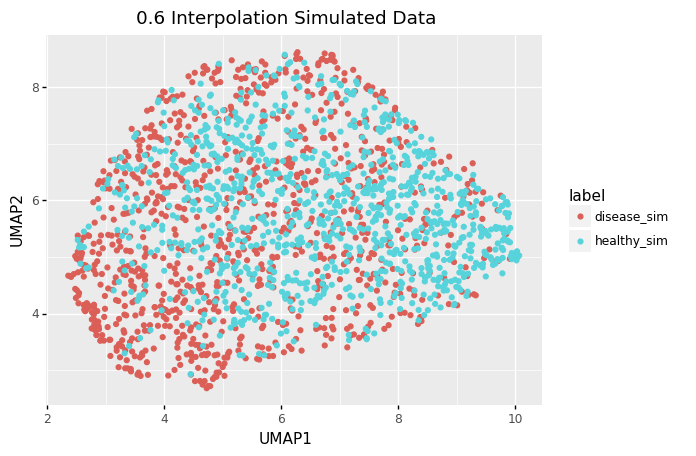

<ggplot: (8742096139161)>

In [22]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('0.6 Interpolation Simulated Data')
plot

#### 0.8 Interpolation Factor

In [23]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_0.8.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,3.368422,5.032214,disease_sim
1,6.183687,7.451210,disease_sim
2,4.660879,5.444067,disease_sim
3,7.438662,5.407124,disease_sim
4,9.235302,4.715060,disease_sim


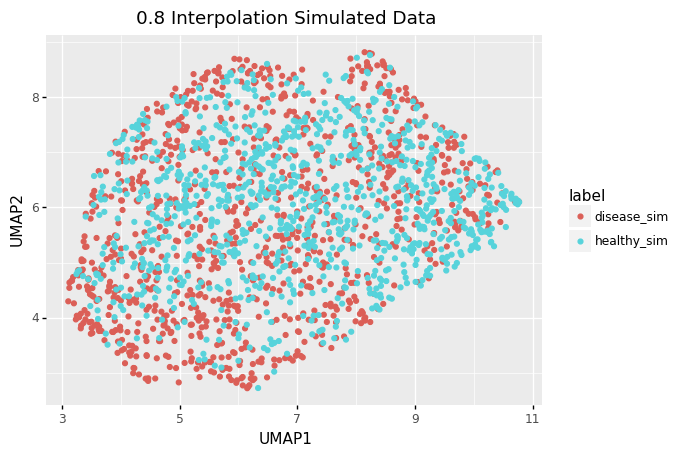

<ggplot: (8742104006617)>

In [24]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('0.8 Interpolation Simulated Data')
plot

#### 1 Interpolation Factor

In [25]:
disease_file = '../../data/simulated/vector/sepsis/joint_sim_disease.pkl'
healthy_file = '../../data/simulated/vector/sepsis/joint_sim_1.0.pkl'

umap_df = embed_data(disease_file, healthy_file)
umap_df.head()

,UMAP1,UMAP2,label
0,2.660434,6.448814,disease_sim
1,6.195586,8.068563,disease_sim
2,4.187112,6.366883,disease_sim
3,7.876946,5.699668,disease_sim
4,9.677771,6.800503,disease_sim


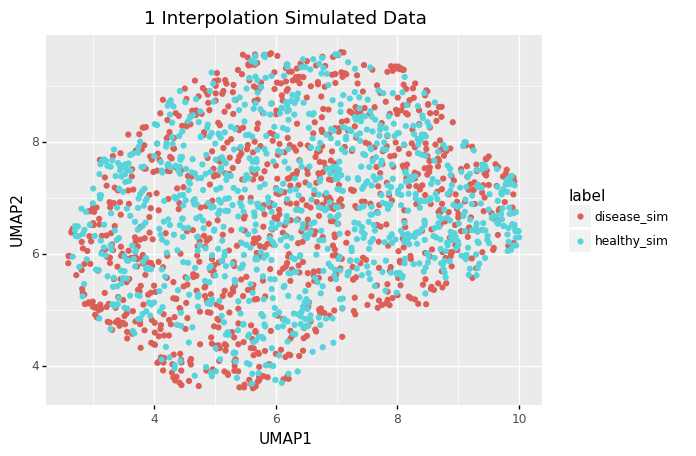

<ggplot: (8742083294621)>

In [26]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='label'))
plot += geom_point()
plot += ggtitle('1 Interpolation Simulated Data')
plot

### Classification Results

In [27]:
in_files = glob.glob('../../results/disease_vector.sepsis*.tsv')
print(in_files[:5])

['../../results/disease_vector.sepsis.logistic_regression_1.1.0.tsv', '../../results/disease_vector.sepsis.pytorch_supervised_0.0.6.tsv', '../../results/disease_vector.sepsis.pytorch_supervised_0.1.0.tsv', '../../results/disease_vector.sepsis.pytorch_lr_1.0.8.tsv', '../../results/disease_vector.sepsis.pytorch_lr_1.1.0.tsv']


In [28]:
sepsis_metrics = pd.DataFrame()
for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('sepsis.')[-1]
    model_info = model_info.split('_')
        
    supervised_model = '{}_{}'.format(model_info[0], model_info[1])
             
    new_df['supervised'] = supervised_model
    
    model_info = model_info[-1].split('.')
    new_df['seed'] = model_info[0]
    new_df['shift_amount'] = '{}.{}'.format(model_info[1], model_info[2])
        
    sepsis_metrics = pd.concat([sepsis_metrics, new_df])
    
sepsis_metrics['train_count'] = sepsis_metrics['train sample count']

sepsis_metrics['supervised'] = sepsis_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')
sepsis_metrics['frac_used'] = sepsis_metrics['fraction of data used'].round(1).astype(str)
sepsis_metrics

,accuracy,balanced_accuracy,f1_score,train studies,train samples,val samples,train sample count,fraction of data used,supervised,seed,shift_amount,train_count,frac_used
0,0.5525,0.552271,0.562347,"sepsis_STUDY_478,healthy_STUDY_415,healthy_STU...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",156,0.1,logistic_regression,1,1.0,156,0.1
1,0.6100,0.609544,0.623188,"healthy_STUDY_63,healthy_STUDY_86,healthy_STUD...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",468,0.3,logistic_regression,1,1.0,468,0.3
2,0.6400,0.638555,0.668203,"sepsis_STUDY_629,sepsis_STUDY_807,healthy_STUD...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",780,0.5,logistic_regression,1,1.0,780,0.5
3,0.6625,0.660914,0.691076,"sepsis_STUDY_629,sepsis_STUDY_701,sepsis_STUDY...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",1092,0.7,logistic_regression,1,1.0,1092,0.7
4,0.6950,0.694178,0.710900,"sepsis_STUDY_818,sepsis_STUDY_121,healthy_STUD...","healthy_956,healthy_565,sepsis_873,sepsis_234,...","healthy_5,healthy_13,healthy_15,healthy_30,hea...",1404,0.9,logistic_regression,1,1.0,1404,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,0.8150,0.815000,0.812183,"sepsis_STUDY_724,healthy_STUDY_753,healthy_STU...","healthy_167,healthy_177,healthy_0,sepsis_627,h...","healthy_3,healthy_10,healthy_11,healthy_22,hea...",160,0.1,logistic_regression,2,0.2,160,0.1
21,0.8400,0.840000,0.841584,"sepsis_STUDY_724,healthy_STUDY_209,sepsis_STUD...","healthy_167,healthy_177,healthy_0,sepsis_627,h...","healthy_3,healthy_10,healthy_11,healthy_22,hea...",480,0.3,logistic_regression,2,0.2,480,0.3
22,0.8475,0.847500,0.849383,"sepsis_STUDY_209,sepsis_STUDY_724,healthy_STUD...","healthy_167,healthy_177,healthy_0,sepsis_627,h...","healthy_3,healthy_10,healthy_11,healthy_22,hea...",800,0.5,logistic_regression,2,0.2,800,0.5
23,0.8600,0.860000,0.862069,"sepsis_STUDY_209,sepsis_STUDY_724,healthy_STUD...","healthy_167,healthy_177,healthy_0,sepsis_627,h...","healthy_3,healthy_10,healthy_11,healthy_22,hea...",1120,0.7,logistic_regression,2,0.2,1120,0.7


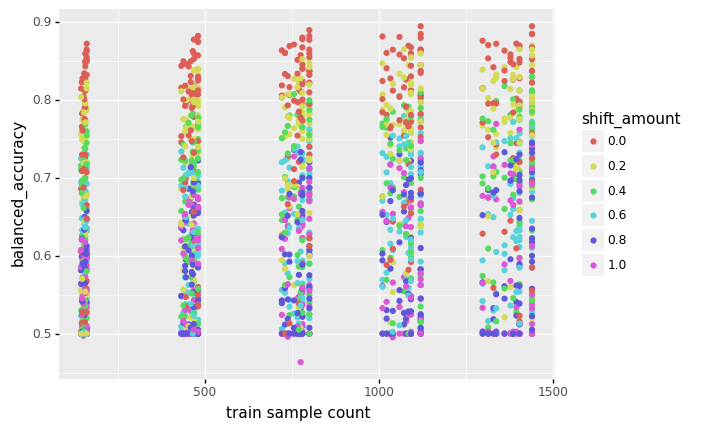

<ggplot: (8742083448965)>

In [29]:
plot = ggplot(sepsis_metrics, aes(x='train sample count', y='balanced_accuracy', color='shift_amount'))
plot += geom_point()
plot

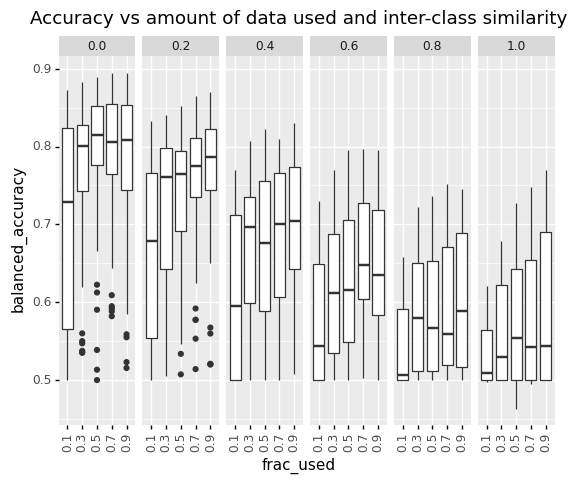

<ggplot: (8742103531597)>

In [30]:
plot = ggplot(sepsis_metrics, aes(x='frac_used', y='balanced_accuracy'))
plot += geom_boxplot()
plot += facet_grid('. ~ shift_amount')
plot += theme(axis_text_x=element_text(angle=90))
plot += ggtitle('Accuracy vs amount of data used and inter-class similarity')
plot

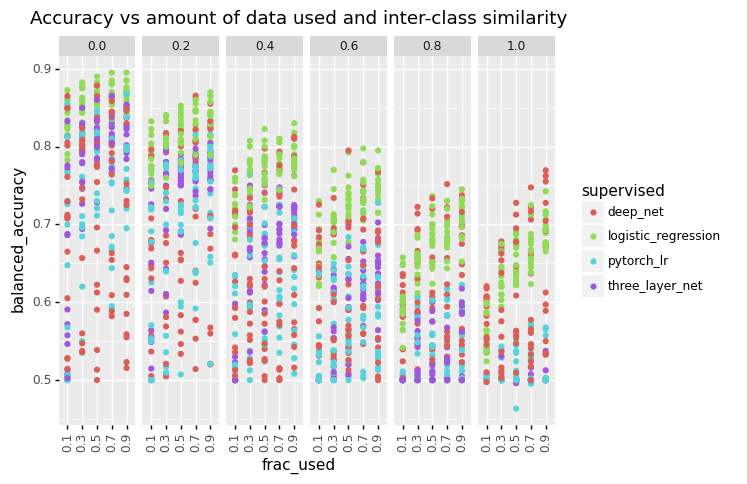

<ggplot: (8742083048749)>

In [31]:
plot = ggplot(sepsis_metrics, aes(x='frac_used', y='balanced_accuracy', color='supervised'))
plot += geom_point()
plot += facet_grid('. ~ shift_amount')
plot += theme(axis_text_x=element_text(angle=90))
plot += ggtitle('Accuracy vs amount of data used and inter-class similarity')
plot

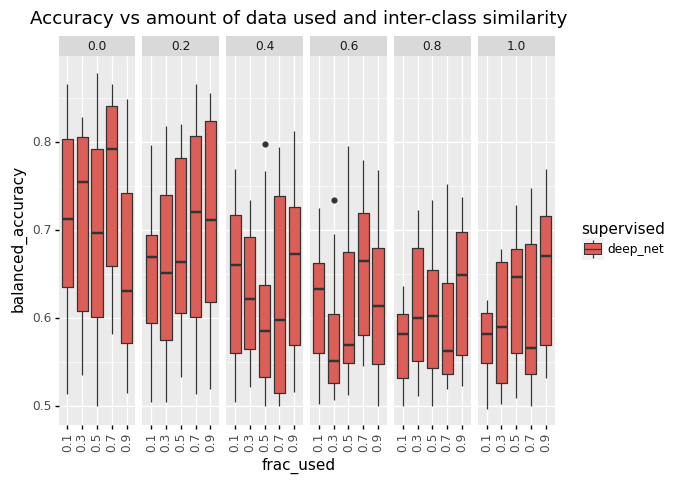

<ggplot: (8742083043729)>

In [32]:
deep_metrics = sepsis_metrics[sepsis_metrics['supervised'] == 'deep_net']
plot = ggplot(deep_metrics, aes(x='frac_used', y='balanced_accuracy', fill='supervised'))
plot += geom_boxplot()
plot += facet_grid('. ~ shift_amount')
plot += theme(axis_text_x=element_text(angle=90))
plot += ggtitle('Accuracy vs amount of data used and inter-class similarity')
plot

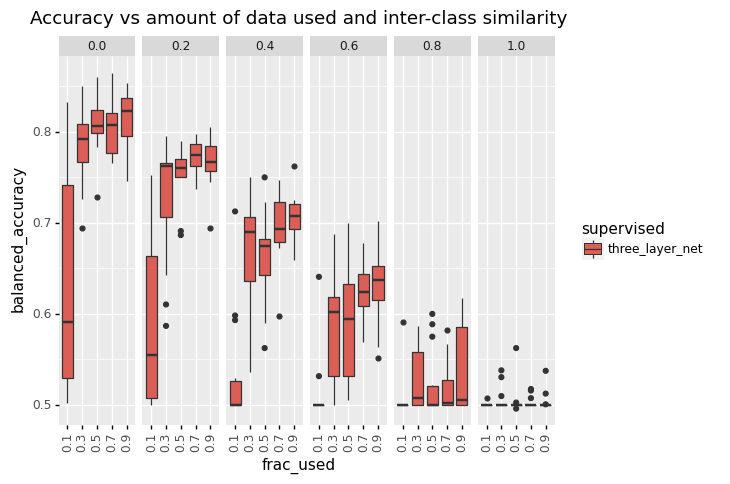

<ggplot: (8742104051421)>

In [33]:
three_metrics = sepsis_metrics[sepsis_metrics['supervised'] == 'three_layer_net']
plot = ggplot(three_metrics, aes(x='frac_used', y='balanced_accuracy', fill='supervised'))
plot += geom_boxplot()
plot += facet_grid('. ~ shift_amount')
plot += theme(axis_text_x=element_text(angle=90))
plot += ggtitle('Accuracy vs amount of data used and inter-class similarity')
plot

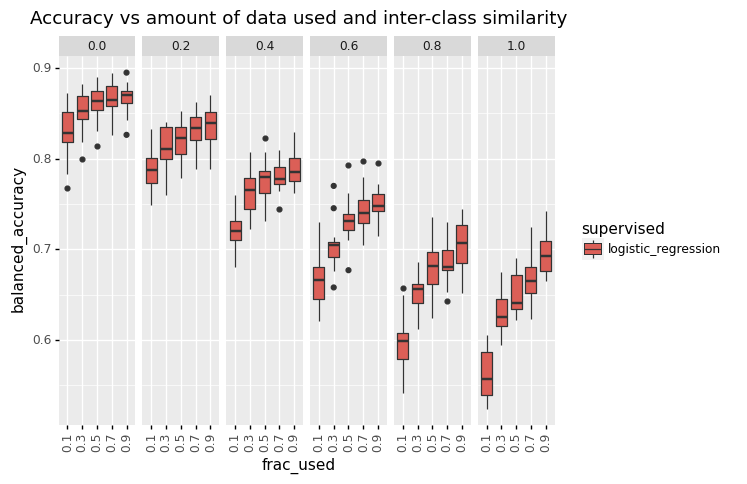

<ggplot: (8742107522589)>

In [34]:
lr_metrics = sepsis_metrics[sepsis_metrics['supervised'] == 'logistic_regression']
plot = ggplot(lr_metrics, aes(x='frac_used', y='balanced_accuracy', fill='supervised'))
plot += geom_boxplot()
plot += facet_grid('. ~ shift_amount')
plot += theme(axis_text_x=element_text(angle=90))
plot += ggtitle('Accuracy vs amount of data used and inter-class similarity')
plot